In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression                                       #linear regression
from sklearn.preprocessing import PolynomialFeatures                                    #polynomial regression
from sklearn.svm import SVR                                                             #simple vector regression
from sklearn.tree import DecisionTreeRegressor                                          #decision tree regressor
from sklearn.ensemble import RandomForestRegressor                                      #random forest regressor
import gurobipy as gp

import torch
from torch import nn

In [2]:
dataset = pd.read_csv('input/adatb_setcover_output.csv')

In [3]:
dataset.head(10)

,policy,seed,type,instance,nnodes,nlps,stime,gap,status,ndomchgs,ncutoffs,walltime,proctime,objval
0,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,2,0.03,0.0,optimal,0,0,0.041468,0.041470,28.0
1,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,8,0.12,0.0,optimal,0,0,0.117496,0.117499,25.0
2,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,3,0.03,0.0,optimal,0,0,0.032750,0.032753,10.0
3,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,2,0.05,0.0,optimal,0,0,0.046181,0.046185,23.0
4,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,1,0.01,0.0,optimal,0,0,0.014738,0.014741,11.0
5,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,26,0.24,0.0,optimal,0,0,0.250231,0.250223,17.0
6,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,30,0.33,0.0,optimal,0,1,0.331593,0.331595,19.0
7,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,37,0.35,0.0,optimal,0,1,0.367199,0.367201,30.0
8,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,2,0.02,0.0,optimal,0,0,0.017138,0.017119,10.0
9,internal:relpscost,0,small,/data/IP-DL/instances/becsogergely/adatb/setco...,1,1,0.02,0.0,optimal,0,0,0.015780,0.015783,32.0


In [4]:
%%capture
for i in range(5000):
    m = gp.read("./train/instance_"+str(i+1)+".lp")                          # reading the LP files
    A = m.getA()                                                             # creating sparse matrix from LP files
    B=A.toarray()                                                            # converting the sparse matrix to ndarray
    dataset.at[i,"instance"]=B                                               # writing this matrix to the dataframe
    

In [5]:
#dropping columns that seem irrelevant

dataset = dataset.drop('policy', axis=1)
dataset = dataset.drop('seed', axis=1)
dataset = dataset.drop('type', axis=1)
dataset = dataset.drop('status', axis=1)

In [6]:
%%capture
m = gp.read("./train/instance_2.lp")                          # reading the LP files
l=[]
for i in range(5000):
    m = gp.read("./train/instance_"+str(i+1)+".lp")
    c = m.getAttr("Obj",m.getVars())
    l=l+[c]


In [7]:
dataset["objective"]=l

In [8]:
dataset.head()


,instance,nnodes,nlps,stime,gap,ndomchgs,ncutoffs,walltime,proctime,objval,objective
0,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2,0.03,0.0,0,0,0.041468,0.041470,28.0,"[19.0, 91.0, 40.0, 51.0, 78.0, 3.0, 84.0, 78.0..."
1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",1,8,0.12,0.0,0,0,0.117496,0.117499,25.0,"[67.0, 4.0, 48.0, 73.0, 9.0, 99.0, 27.0, 61.0,..."
2,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,3,0.03,0.0,0,0,0.032750,0.032753,10.0,"[22.0, 48.0, 71.0, 56.0, 16.0, 24.0, 17.0, 44...."
3,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,...",1,2,0.05,0.0,0,0,0.046181,0.046185,23.0,"[31.0, 88.0, 70.0, 27.0, 76.0, 45.0, 29.0, 37...."
4,"[[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0,...",1,1,0.01,0.0,0,0,0.014738,0.014741,11.0,"[62.0, 4.0, 53.0, 1.0, 46.0, 24.0, 50.0, 72.0,..."


In [9]:
#Insert 'objective' to the instances

for i in range(5000):
    x=0
    ins = dataset['instance'][i]
    obj = dataset['objective'][i]
    b =np.array(obj)
    c= b.reshape(1,200)
    x = np.concatenate((ins, c), axis=0)
    dataset.at[i,"instance"]=x

In [10]:
#dataset.to_csv("adatb_matrixos_adathalmaz.csv")

most kezdődik a, most kezdődik a, most kezdődik a... ...z AI.
 

In [11]:
#custom dataset class,
class CustomIPDataset(torch.utils.data.Dataset):
    def __init__(self, dataFrame):
        self.instances = dataFrame['instance']
        self.target_values = dataFrame['nlps']

    def __len__(self):
        return len(self.instances)
    
    def __getitem__(self, idx):
        instance = self.instances[idx]
        target_value=self.target_values[idx]
        return instance, target_value

In [12]:
#custom dataset

#dividing the data into test and train instances
#first, lets try by the naive first 4500 train, rest 500 is test
train_df = dataset.head(4500)
test_df= dataset.tail(500)
test_df.reset_index(drop=True, inplace=True)

training_data= CustomIPDataset(train_df)
test_data= CustomIPDataset(test_df)

In [13]:
#dataloaders
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=50, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)


In [14]:
# Set the runtime environment to GPU in
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

#GPU usage:
gpu=1

if gpu == -1:
    device = torch.device("cpu")
else:
    cuda = "cuda:"+str(gpu)
    device = torch.device(cuda if torch.cuda.is_available() else "cpu")

Using GPU device: NVIDIA GeForce RTX 2080 Ti


In [15]:
#creating a simple-basic neural network modell, trying to reduce the parameterspace in the first layer. \n",
from torch import nn

class DenseNetwork(nn.Module):
    def __init__(self):
        super(DenseNetwork, self).__init__()
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(101*200, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [16]:
#Initialize and move network to cuda
model = DenseNetwork().to(device)
print(model)

DenseNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20200, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [17]:
# Initialize the loss function
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = torch.Tensor(x).type(torch.FloatTensor).to(device)
        Y = torch.Tensor(y).type(torch.FloatTensor).to(device)
        pred = model(X)
        #print(\"sum(pred)\")
        #print(pred)
        Y = Y.view(50,1)
        #print("sum(y)"")
        #print(Y)
        loss = loss_fn(pred, Y)
        #print(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            print(f"Train loss: {loss:>11f}")
    return loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            X = torch.Tensor(x).type(torch.FloatTensor).to(device)
            Y = torch.Tensor(y).type(torch.FloatTensor).to(device)
            Y = Y.view(50,1)
            pred = model(X)
            test_loss += loss_fn(pred, Y).item()

    test_loss /= num_batches
    print(f"Avg test loss: {test_loss:>8f}" )
    return test_loss

In [20]:
epochs = 50
train_losses= []
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    
    train_losses.append(float(train_loss))
    test_losses.append(float(test_loss))
    print("Done!")

Epoch 1
-------------------------------
Train loss:  242.396790
Avg test loss: 204.252885
Done!
Epoch 2
-------------------------------
Train loss:  197.724808
Avg test loss: 204.083228
Done!
Epoch 3
-------------------------------
Train loss:  152.601624
Avg test loss: 199.443498
Done!
Epoch 4
-------------------------------
Train loss:  203.058121
Avg test loss: 205.430246
Done!
Epoch 5
-------------------------------
Train loss:  152.508026
Avg test loss: 234.327921
Done!
Epoch 6
-------------------------------
Train loss:   60.917770
Avg test loss: 242.724167
Done!
Epoch 7
-------------------------------
Train loss:   21.514137
Avg test loss: 258.599619
Done!
Epoch 8
-------------------------------
Train loss:   15.851128
Avg test loss: 249.814078
Done!
Epoch 9
-------------------------------
Train loss:    8.613571
Avg test loss: 254.912383
Done!
Epoch 10
-------------------------------
Train loss:    8.269043
Avg test loss: 245.958223
Done!
Epoch 11
------------------------------

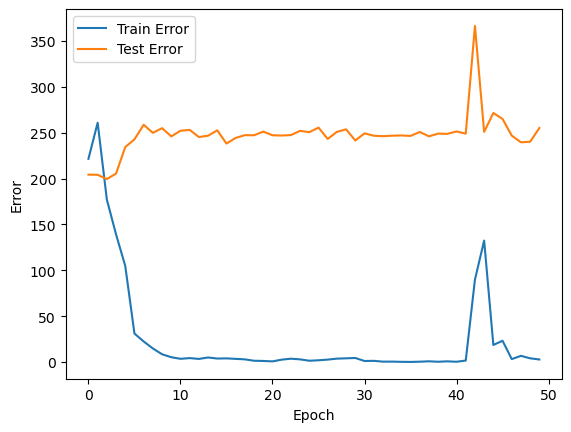

In [21]:
def plot_errors(train_errors, test_errors):
  plt.plot(train_errors, label='Train Error')
  plt.plot(test_errors, label='Test Error')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.show()

train_errors = train_losses
test_errors = test_losses
plot_errors(train_errors, test_errors)

In [22]:
#print(train_errors)
#print(test_errors)

[221.50491333007812, 260.810791015625, 177.0772247314453, 139.1460723876953, 104.77206420898438, 31.09375, 22.48733901977539, 14.848532676696777, 8.53953742980957, 5.324008464813232, 3.581620693206787, 4.369477272033691, 3.457033395767212, 5.022537708282471, 3.8788065910339355, 4.045823097229004, 3.5079312324523926, 2.977792978286743, 1.4553256034851074, 1.2517650127410889, 0.7749648690223694, 2.6655049324035645, 3.6906075477600098, 2.9697771072387695, 1.489560842514038, 1.9676259756088257, 2.7216522693634033, 3.7703678607940674, 4.111412048339844, 4.486525058746338, 1.1854329109191895, 1.3611431121826172, 0.5042917728424072, 0.5337718725204468, 0.3017040491104126, 0.1893521398305893, 0.4443579912185669, 0.8704449534416199, 0.3850156366825104, 0.8274307250976562, 0.36040014028549194, 1.6869447231292725, 89.84503936767578, 132.40606689453125, 18.651927947998047, 23.24991226196289, 3.266901731491089, 6.8156256675720215, 4.104196548461914, 2.8394615650177]
[204.2528854370117, 204.08322753